In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib notebook

In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dic = pd.read_csv('./train.csv')
# dict({dic["fname"]:dic["label"]})
class_map_train = dic[["fname","label"]]
class_map_train.index = class_map_train["fname"]
class_map_train = class_map_train.drop(["fname"],axis=1)
class_map_train = class_map_train.to_dict()["label"]
class_map_train
dic = pd.read_csv('./test_post_competition.csv')
dic = dic[dic["label"]!="None"]
class_map_test = dic[["fname","label"]]
class_map_test.index = class_map_test["fname"]
class_map_test = class_map_test.drop(["fname"],axis=1)
class_map_test = class_map_test.to_dict()["label"]
class_map_test

{'00326aa9.wav': 'Oboe',
 '0038a046.wav': 'Bass_drum',
 '007759c4.wav': 'Saxophone',
 '008afd93.wav': 'Saxophone',
 '00ae03f6.wav': 'Chime',
 '00eac343.wav': 'Electric_piano',
 '010a0b3a.wav': 'Shatter',
 '01a5a2a3.wav': 'Bark',
 '01bb344f.wav': 'Acoustic_guitar',
 '02107093.wav': 'Electric_piano',
 '02198549.wav': 'Scissors',
 '023eab1f.wav': 'Double_bass',
 '028db587.wav': 'Double_bass',
 '02960f07.wav': 'Scissors',
 '02fb6c5b.wav': 'Knock',
 '030db750.wav': 'Telephone',
 '03319789.wav': 'Violin_or_fiddle',
 '0381efd3.wav': 'Double_bass',
 '03c5bfbb.wav': 'Gunshot_or_gunfire',
 '0422b811.wav': 'Burping_or_eructation',
 '0459ee65.wav': 'Clarinet',
 '04605af5.wav': 'Shatter',
 '046486df.wav': 'Computer_keyboard',
 '047bf19c.wav': 'Flute',
 '04ab46a9.wav': 'Cello',
 '04ab4e22.wav': 'Tambourine',
 '04b249bd.wav': 'Drawer_open_or_close',
 '04ecda67.wav': 'Bass_drum',
 '053e7bb5.wav': 'Snare_drum',
 '05723b3a.wav': 'Cello',
 '057425e6.wav': 'Fart',
 '0586f0e0.wav': 'Meow',
 '058e63ea.wav':

In [5]:
label_map = list(dic["label"].unique())
label_map = {label_map[i]:i for i in range(len(label_map))}

## Loading

In [21]:
import librosa
import numpy as np
import librosa.display
import time 
import gc #（garbage collector）

audio_dir_train = './FSDKaggle2018.audio_train/'
audio_dir_test = './FSDKaggle2018.audio_test/'
path_to_db_train='./FSD_train/'
path_to_db_test = "./FSD_test/"

SR = 16000
overlap = 0 #int(SR/4)

duration = 5
sample_length = 44100 * duration
for dir_path in [audio_dir_test,audio_dir_train]:
    if dir_path==audio_dir_train:
        class_map = class_map_train
    else:
        class_map = class_map_test
    for fileList in os.walk(dir_path):
        count = 0
        for fname in fileList[2]:
            t1 = time.time()
            name = fname[:-4]
            try:
                curr_class = class_map[fname]
                count += 1
                fpath = dir_path + fname
                (samples, rate) = librosa.load(fpath, sr=None, mono=True,  dtype=np.float32)
                if len(samples) > sample_length: # long enough
                    samples = samples[0:sample_length]
                else: # pad blank
                    padding = sample_length - len(samples)
                    offset = padding // 2
                    if len(samples) == 0:
                        samples = np.pad(samples, (offset, sample_length - len(samples) - offset), 'constant')
                    else:
                        while(len(samples)<sample_length):
                            padding = sample_length - len(samples)
                            samples = np.append(samples, samples[0:padding], axis=0)
                S = librosa.feature.melspectrogram(y=samples, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
                S_dB = librosa.power_to_db(S, ref=np.max)

                if dir_path== audio_dir_train:
                    save_dir = path_to_db_train + curr_class +'/'
                else:
                    save_dir = path_to_db_test + curr_class +'/'
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                np.save(save_dir + name + '.npy',S_dB)
                t2 = time.time()
                if count%100 ==0:
                    print(count, t2-t1)
            except:
                pass


100 0.04088401794433594
200 0.04257464408874512
300 0.040508270263671875
400 0.03988528251647949
500 0.04057741165161133
600 0.0438237190246582
700 0.04286694526672363
800 0.03974413871765137
900 0.04075336456298828
1000 0.04013633728027344
1100 0.039762258529663086
1200 0.04050898551940918
1300 0.04013347625732422
1400 0.044834136962890625
1500 0.04107332229614258
1600 0.04011964797973633
100 0.04724478721618652
200 0.04568219184875488
300 0.04735302925109863
400 0.04591202735900879
500 0.058379411697387695
600 0.04464578628540039
700 0.04614973068237305
800 0.04527783393859863
900 0.05534791946411133
1000 0.05371904373168945
1100 0.04680442810058594
1200 0.08916139602661133
1300 0.04257464408874512
1400 0.04433274269104004
1500 0.046484947204589844
1600 0.04927706718444824
1700 0.05053424835205078
1800 0.04680895805358887
1900 0.05008959770202637
2000 0.04732489585876465
2100 0.0486142635345459
2200 0.0455021858215332
2300 0.05548691749572754
2400 0.04557204246520996
2500 0.049643516

## Estimator

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 9)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.norm = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(7, 7)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout2d(p=0.2)
#         self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,41)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, (3,6))
#         self.norm1 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(2, 4)
#         self.conv2 = nn.Conv2d(64, 32, (3,6))
#         self.norm2 = nn.BatchNorm2d(32)
#         self.pool2 = nn.MaxPool2d(2, 4)
#         self.conv3 = nn.Conv2d(32, 32, (3,6))
#         self.norm3 = nn.BatchNorm2d(32)
#         self.pool3 = nn.MaxPool2d(2,2)
        
#         self.fc1 = nn.Linear(960, 41)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64,41)
# #         self.fc4 = nn.Linear(64,41)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.norm2(x)
#         x = F.relu(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.norm3(x)
#         x = F.relu(x)
#         x = self.pool3(x)
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)
# #         x = F.relu(x)
# #         x = self.dropout(x)
# #         x = self.fc2(x)
# #         x = F.relu(x)
# #         x = self.dropout(x)
# #         x = self.fc3(x)

#         x = self.softmax(x)
#         return x

In [10]:
# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 9)
#         self.conv2 = nn.Conv2d(32, 32, 5)
#         self.norm = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(7, 7)
#         self.fc1 = nn.Linear(256, 128)
#         self.dropout = nn.Dropout2d(p=0.2)
# #         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(64,50)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.norm(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = self.norm(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x)
#         x = F.relu(x)
# #         x = self.fc2(x)
# #         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc3(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.fc4(x)
#         x = self.softmax(x)
#         return x

In [8]:
# load data:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class dataset(Dataset):
    def __init__(self, mode):
        
        if mode=="train":
            root_dir = './FSD_train/'
        else:
            root_dir = './FSD_test/'
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk(root_dir):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    if mode == "train":
                        self.label_list.append(label_map[root[12:]])
                    else:
                        self.label_list.append(label_map[root[11:]])
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label
    
# dataset = dataset("train")
# dataset.__getitem__(0)
# max_val = 0
# res = []
# for i in range(1600): 
#     data,label = dataloader.__getitem__(i)
#     if data.shape[2] >max_val:
#         max_val = data.shape[2]
#     res.append(data.shape[2])
# print(max_val)
# print(Counter(res))

In [23]:
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR

model = Net()
model = model.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 9473
batchsize = 64

trainset  = dataset("train")
testset  = dataset("test")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(50):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    training_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
    
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

107154
9473 9473
1600 1600
===========Phase: Val============
Validation Time: 2.4992425441741943
Epoch: 0  val_loss: 3.7133907890319824
Epoch: 0  val_accuracy: 0.028125
===========Phase: Train============
Training Time: 28.317792654037476
Epoch: 0  train_loss: 3.5907506510715357
Epoch: 0  train_accuracy: 0.1772021812080537

===========Phase: Val============
Validation Time: 2.470696449279785
Epoch: 1  val_loss: 3.5972210597991943
Epoch: 1  val_accuracy: 0.1625
===========Phase: Train============
Training Time: 28.026386976242065
Epoch: 1  train_loss: 3.476826256553599
Epoch: 1  train_accuracy: 0.29335151006711413

===========Phase: Val============
Validation Time: 2.4655542373657227
Epoch: 2  val_loss: 3.5477174854278566
Epoch: 2  val_accuracy: 0.21375
===========Phase: Train============
Training Time: 27.96207618713379
Epoch: 2  train_loss: 3.428622849035583
Epoch: 2  train_accuracy: 0.3446602348993289

===========Phase: Val============
Validation Time: 2.458153486251831
Epoch: 3  val

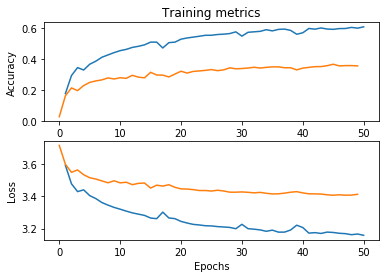

In [24]:
x_axis = np.linspace(1,50,50)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR

model = Net()
model = model.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 9473
batchsize = 64

trainset  = dataset("train")
testset  = dataset("test")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(50):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    training_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        inputs = inputs.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
    
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

72137
9473 9473
1600 1600
===========Phase: Val============
Validation Time: 1.3886921405792236
Epoch: 0  val_loss: 3.7135970211029052
Epoch: 0  val_accuracy: 0.02875
===========Phase: Train============
Training Time: 14.77895212173462
Epoch: 0  train_loss: 3.6839965541890805
Epoch: 0  train_accuracy: 0.05860318791946309

===========Phase: Val============
Validation Time: 1.3160433769226074
Epoch: 1  val_loss: 3.6830520534515383
Epoch: 1  val_accuracy: 0.066875
===========Phase: Train============
Training Time: 14.909379720687866
Epoch: 1  train_loss: 3.6360638413653277
Epoch: 1  train_accuracy: 0.11611577181208053

===========Phase: Val============
Validation Time: 1.3113288879394531
Epoch: 2  val_loss: 3.683220624923706
Epoch: 2  val_accuracy: 0.068125
===========Phase: Train============
Training Time: 14.930851936340332
Epoch: 2  train_loss: 3.624034590369103
Epoch: 2  train_accuracy: 0.13007130872483222

===========Phase: Val============
Validation Time: 1.3278696537017822
Epoch: 3